<a href="https://colab.research.google.com/github/NguyenChHieu/FashionMNISTV2/blob/main/conv2_derived_TinyVGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

print(torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Get the data model
train_data = datasets.FashionMNIST(
    root = "data", # where to dload data to?
    train = True, # do we want the training dataset,
    download = True, # want to download?
    transform = torchvision.transforms.ToTensor(),
    target_transform = None)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor(),
    target_transform = None
)

2.2.1+cu121


100%|██████████| 26421880/26421880 [00:00<00:00, 116941532.05it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 7047013.30it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 64881833.95it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19227317.00it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



# Check inputs, outputs of the dataset

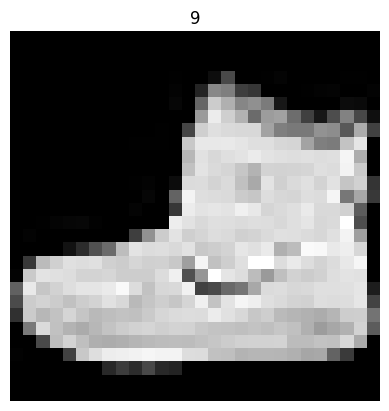

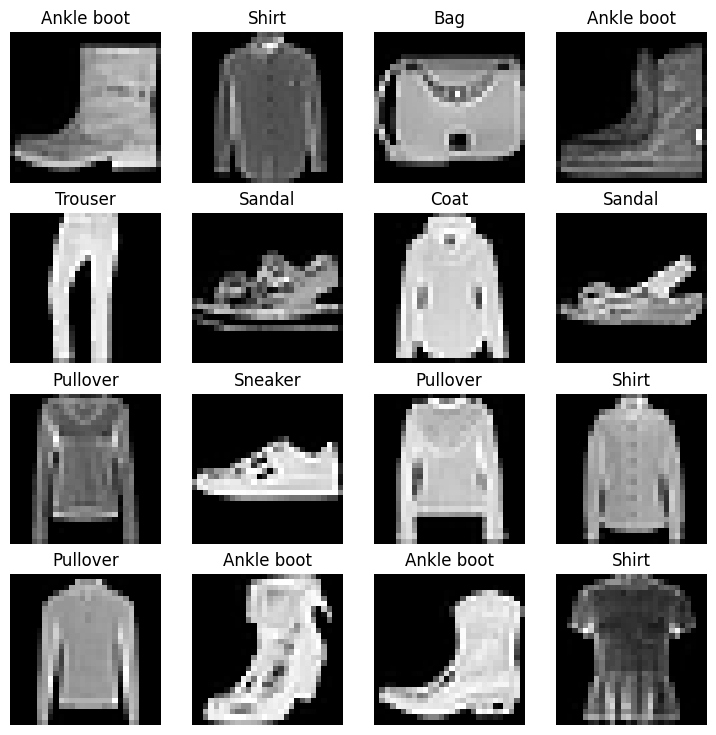

In [2]:
image, label = train_data[0]
class_names = train_data.classes
#shape: image.shape
#label: class_names[label]

plt.imshow(image.squeeze(), cmap="gray") # delete cmap for colored version
plt.title(label)
plt.axis(False)

#plot more img
torch.manual_seed(42)
fig = plt.figure(figsize = (9,9))
rows, cols = 4,4
for i in range(1, rows*cols +1):
  random_idx = torch.randint(0, len(train_data), size = [1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap = "gray")
  plt.title(class_names[label])
  plt.axis(False)

# Prepare a dataloader - data to be trained/tested for CNNs

Image size: torch.Size([1, 28, 28])
Label: 6, label size: torch.Size([])


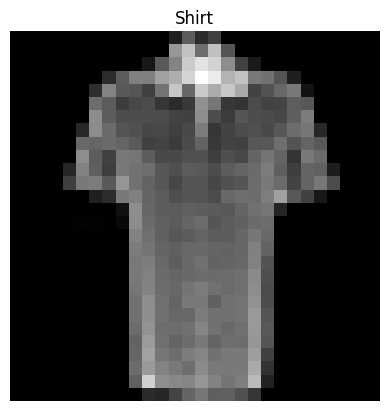

In [3]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True)
test_dataloader  = DataLoader(dataset = test_data,
                              batch_size = BATCH_SIZE,
                              shuffle = False)

train_features_batch, train_labels_batch = next(iter(train_dataloader))

# Show a sample
torch.manual_seed(42)
idx = torch.randint(0, len(train_features_batch), size = [1]).item()
img, label = train_features_batch[idx], train_labels_batch[idx]
plt.imshow(img.squeeze(), cmap= "gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

# CNN Model

In [4]:
class FashionMNISTV2(nn.Module):
  """
  Model architure replicates the TinyVGG
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(

        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1), # values we can set in NN's are called hyperparameters
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2))
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1,),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2))
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units * 7 * 7, # We got the value "x*7*7" = trace back the outputs by passing in a dummy tensor, analyzing the outputs(Flatten(),Conv_layer outputs.)
                  out_features = output_shape))
  def forward(self,x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    return x

# Functionalized training step

In [5]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  ## Training
  train_loss, train_acc = 0,0
  model.train()

  # BATCH LOOP
  for batch, (X, y) in enumerate(train_dataloader):
    # put data on target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate loss and acc (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss
    train_acc += accuracy_fn(y_true = y,
                             y_pred = y_pred.argmax(dim = 1)) # go from logits -> pred labels

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss bw
    loss.backward()

    # 5. optim step
    optimizer.step()

  # Divide total train loss and acc by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")


# Functionalized test step

In [6]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  test_loss, test_acc = 0,0
  model.eval()

  with torch.inference_mode():
    for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)
      # 1. Forward pass
      test_pred = model(X)

      # 2. cal loss (accumulatively)
      test_loss += loss_fn(test_pred, y)

      # 3. Calculate accuracy
      test_acc += accuracy_fn(y_true = y,
                              y_pred = test_pred.argmax(dim = 1))

    # cal the test loss avg/batch
    test_loss /= len(test_dataloader)
    # calculate the test acc avg per batch
    test_acc /= len(test_dataloader)

    # Print out
    print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

# Model for evaluation

In [7]:
def eval_model(model : torch.nn.Module,
               data_loader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               accuracy_fn,
               device: torch.device):
  """ Returns a dict containing the results of model predicting on dataloader"""
  loss, acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      X, y = X.to(device), y.to(device)

      # make pred
      y_pred = model(X)

      # ACCU the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim=1))

    # scale loss and acc to find the avg loss/ acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)
  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}

# Helper functions

## Accuracy function

In [8]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## Measure time taken

In [9]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device):
  """Prints diff between start and end time"""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

# Put it all together

In [10]:
from tqdm.auto import tqdm # progress bar

torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_2 = FashionMNISTV2(input_shape = 1,
                         hidden_units = 10,
                         output_shape = len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_2.parameters(),
                            lr = 0.1)


# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

epochs =3
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  # train_step
  train_step(model = model_2,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn = accuracy_fn,
             device = device)
  # test_step
  test_step(model= model_2,
            data_loader = test_dataloader,
            loss_fn = loss_fn,
            accuracy_fn = accuracy_fn,
            device = device)
train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start = train_time_start_model_2,
                                            end = train_time_end_model_2,
                                            device = device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.57971 | Train acc: 78.99%
Test loss: 0.3882, Test acc: 85.6130
Epoch: 1
-------
Train loss: 0.35723 | Train acc: 87.17%
Test loss: 0.3655, Test acc: 86.3518
Epoch: 2
-------
Train loss: 0.31850 | Train acc: 88.41%
Test loss: 0.3271, Test acc: 88.2288
Train time on cuda: 38.731 seconds


# Visualize predictions

In [11]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # prepare the sample (add a batch dimension and pass to target device)
      sample = torch.unsqueeze(sample, dim = 0).to(device)

      # Forward pass (model outputs raw logits)
      pred_logit = model(sample)

      # Get prediction probability
      pred_prob = torch.softmax(pred_logit.squeeze(), dim = 0)

      # Get pred prob off gpu
      pred_probs.append(pred_prob.cpu())

  # stack the pred probs to turn list into a tensor
  return torch.stack(pred_probs)

## Create test samples

In [12]:
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k = 9):
  test_samples.append(sample)
  test_labels.append(label)

## Create prediction model

In [13]:
pred_probs = make_predictions(model = model_2,
                              data = test_samples,
                              device = device)
# pred prob to labels
pred_classes = pred_probs.argmax(dim = 1)

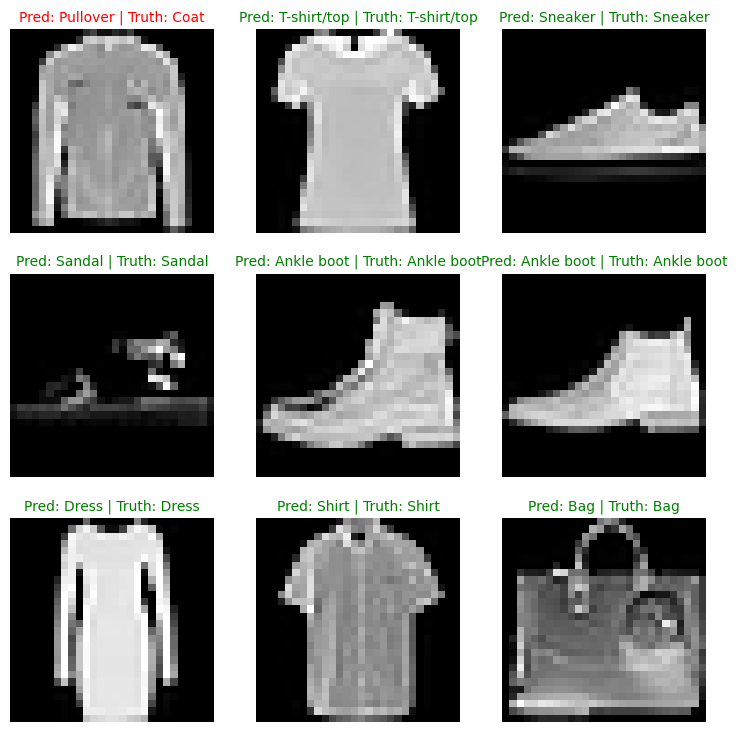

In [14]:
# plot pred
plt.figure(figsize =(9,9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  # plot target image
  plt.imshow(sample.squeeze(), cmap = "gray")

  # Find the prediction (in text form, e.g "Sandal")
  pred_label = class_names[pred_classes[i]]

  # get the truth label (in text form)
  truth_label = class_names[test_labels[i]]

  # title for the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # check for == between pred and truth and change color of title txt
  if pred_label == truth_label:
    plt.title(title_text, fontsize = 10, c = "g") # correct
  else:
    plt.title(title_text, fontsize = 10, c = "r")

  plt.axis(False)

# Making a confusion matrix for further prediction evaluation

In [16]:
from tqdm.auto import tqdm

# make pred with trained model
y_preds =[]
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc = "Making_predictions..."):
    # set correct dvice
    X,y = X.to(device), y.to(device)
    # get raw data
    y_logit = model_2(X)
    # logit -> pred probs
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim = 1)
    # put pred on cpu
    y_preds.append(y_pred.cpu())

  # concat list of preds into a tensor
  y_pred_tensor = torch.cat(y_preds)

Making_predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

In [17]:
# try import packages, if not installed then install
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend version should be 0.19.0 or higher"
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend verion: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 91.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

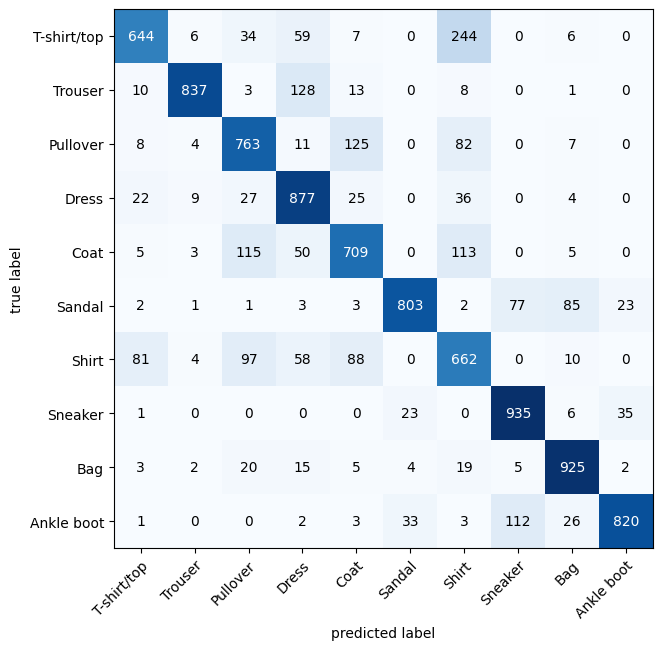

In [18]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task = 'multiclass',num_classes = len(class_names))
confmat_tensor = confmat(preds = y_pred_tensor,
                         # test_data.targets -> tensor([9,1,2.....,8]) - labels
                         target = test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(), # matplotlib likes working with numpy
    class_names = class_names,
    figsize = (10,7)
)